# ATUA 2026: Spatial Regression
## Authors: Dr Zixin Feng, Prof. Qunshan Zhao

This notebook provides a step-by-step introduction to spatial regression modelling. We demonstrate how to move from a standard OLS regression to spatial econometric models (Spatial Error, Spatial Lag, and Spatial Durbin models) when spatial dependency is detected in the data.

1. Construct standard OLS model
2. Construct spatial weight matrices 
3. Diagnose spatial autocorrelation using Moran's I
4. Apply Lagrange Multiplier (LM) tests and Likelihood Ratio (LR) test for model selection
5. Estimate and interpret spatial regression models

**Background Knowledge**: We assume you have basic understanding of standard OLS model from your QDA course, and understand spatial weight matrices and spatial autocorrelation from your GIS course. 

**Data:** Inside Airbnb listings for Bristol, UK

https://insideairbnb.com/get-the-data/

**Dependent Variable (Y):** Log-transformed listing price

**Question:** What's the influencing factors of Airbnb price and how to fit the most appropriate (spatial) model to explain it? 

To help you all to recap the memory from QDA, the general assumptions of **Ordinary Least Squares (OLS)** are often grouped into the LINE acronym. 

The LINE Acronym:

**L - Linearity**: The relationship between the independent variables ($X$) and the dependent variable ($Y$) is linear. Specifically, the model must be linear in its parameters (coefficients).

**I – Independence**: The residuals (errors) are independent of each other. In other words, the error for one observation tells you nothing about the error for another. 

**N – Normality**: For any fixed value of $X$, the residuals follow a Normal Distribution. This is primarily required for the $p$-values and confidence intervals to be valid. 

**E – Equality of Variance (Homoscedasticity)**: The "spread" or variance of the residuals is constant across all levels of the independent variables.

Two more things: 

**No Multicollinearity**: The independent variables are not perfectly (or highly) correlated with each other. This is why we check VIF later in the model. 

**Exogeneity**: The independent variables are not correlated with the error term (i.e., there are no "omitted variables" that are also correlated with our $X$ variables).

But as you can imagine, when we work with real world datasets, particularly the spatial datasets, we will violate many assumptions for OLS regression, particularly for the **Independence** assumption due to the **spatial dependence** and **spatial autocorrelation**. We will show how to detect these in this class and also how to use spatial regression to address it. 

**A general rule of thumbs: It is always very important to have the best and robust OLS regression fitted, before moving to any other more complicated regression framework.** 

In [101]:
# Python Environment Version Checking
%reload_ext watermark
%watermark -v -p pandas,numpy,geopandas,libpysal,esda,spreg,contextily,splot,scipy,matplotlib

Python implementation: CPython
Python version       : 3.14.3
IPython version      : 9.10.0

pandas    : 3.0.0
numpy     : 2.3.5
geopandas : 1.1.2
libpysal  : 4.14.1
esda      : 2.8.1
spreg     : 1.8.5
contextily: 1.7.0
splot     : 1.1.7
scipy     : 1.17.0
matplotlib: 3.10.8



In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd
import seaborn as sns
from libpysal.weights import DistanceBand, KNN
from esda.moran import Moran
from spreg import OLS, ML_Error, ML_Lag, GM_Error, GM_Lag
from scipy import stats
from shapely.geometry import Point
from splot.esda import moran_scatterplot, plot_moran
import contextily as ctx
from matplotlib.ticker import FuncFormatter
import pyproj
from libpysal.weights import lag_spatial
from scipy.stats import norm

### 1 Load and explore the dataset

In [63]:
df = pd.read_csv(r'Data/listings.csv.gz')

For the spatial regression, we need to select meaningful independent variables (X) that explain listing price (Y), along with coordinates for spatial analysis.


| Variable | Type | Rationale |
|---|---|---|
| `log_price` | Dependent (Y) | Log-transformed listing price per night |
| `accommodates` | Property | Maximum guest capacity |
| `bedrooms` | Property | Number of bedrooms |
| `bathrooms` | Property | Number of bathrooms |
| `room_type` | Property | Entire home vs private room vs shared room (dummy encoded) |
| `is_superhost` | Host | Superhost status as a trust and quality signal |
| `review_scores_rating` | Demand | Overall guest rating as a quality indicator |
| `reviews_per_month` | Demand | Frequency of bookings as a popularity proxy |
| `availability_365` | Supply | Days available per year — supply-side indicator |
| `minimum_nights` | Policy | Minimum stay requirement — booking flexibility |
| `is_instant_bookable` | Policy | Whether guests can book without host approval |

### 2 Clean the variables 

In [70]:
# Clean price 
df['price'] = df['price'].replace(r'[\$,]', '', regex=True).astype(float)

In [71]:
# Select variables
cols = [
    'id', 'latitude', 'longitude', 'price',
    'room_type', 'accommodates', 'bedrooms', 'bathrooms_text',
    'host_is_superhost', 'instant_bookable',
    'reviews_per_month',
    'review_scores_rating',
    'availability_365', 'minimum_nights',
    'neighbourhood_cleansed'
]

df_clean = df[cols].copy()


In [72]:
# ---- Clean bathrooms ----
df_clean['bathrooms'] = df_clean['bathrooms_text'].str.extract(r'(\d+\.?\d*)').astype(float)
df_clean = df_clean.drop(columns='bathrooms_text')

# ---- Encode binary variables ----
df_clean['is_superhost'] = (df_clean['host_is_superhost'] == 't').astype(int)
df_clean['is_instant_bookable'] = (df_clean['instant_bookable'] == 't').astype(int)
df_clean = df_clean.drop(columns=['host_is_superhost', 'instant_bookable'])

# ---- Create room type dummies ----
# Reference category: 'Entire home/apt'
room_dummies = pd.get_dummies(df_clean['room_type'], prefix='room', drop_first=False)

# Keep interpretable dummies (drop 'Entire home/apt' as reference)
if 'room_Entire home/apt' in room_dummies.columns:
    room_dummies = room_dummies.drop(columns='room_Entire home/apt')
df_clean = pd.concat([df_clean, room_dummies], axis=1)

In [73]:
# ---- Drop missing values in key variables ----
key_cols = ['price', 'latitude', 'longitude', 'bedrooms',
            'bathrooms', 'review_scores_rating', 'accommodates',
            'reviews_per_month', 'availability_365', 'minimum_nights',
            'is_superhost', 'is_instant_bookable']
df_clean = df_clean.dropna(subset=key_cols)

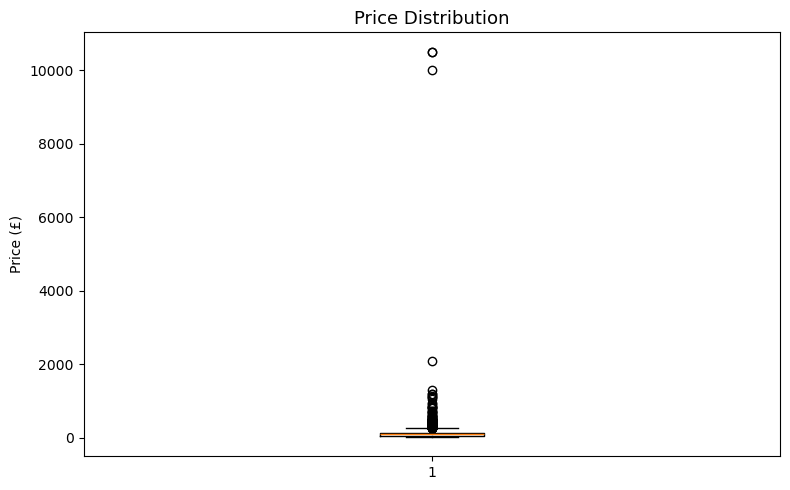

In [74]:
# explore price outliers
fig, ax = plt.subplots(figsize=(8, 5))

ax.boxplot(df_clean['price'], vert=True)
ax.set_title('Price Distribution', fontsize=13)
ax.set_ylabel('Price (£)')

plt.tight_layout()
plt.show()

In [75]:
# ---- Remove price outliers ----
#df_clean = df_clean[df_clean['price'] <= 500]
#df_clean = df_clean.reset_index(drop=True)
#print(f"After removing price > £500: {len(df_clean)}")

# Remove top 1% price outliers
price_99th = df_clean['price'].quantile(0.99)
df_clean = df_clean[df_clean['price'] <= price_99th]
df_clean = df_clean.reset_index(drop=True)

print(f"99th percentile price: £{price_99th:.2f}")
print(f"After removing top 1%: {len(df_clean)} listings")

99th percentile price: £718.84
After removing top 1%: 1913 listings


In [ ]:
# Log-transform price to reduce skewness and stabilize variance for regression analysis 
df_clean['log_price'] = np.log(df_clean['price'])

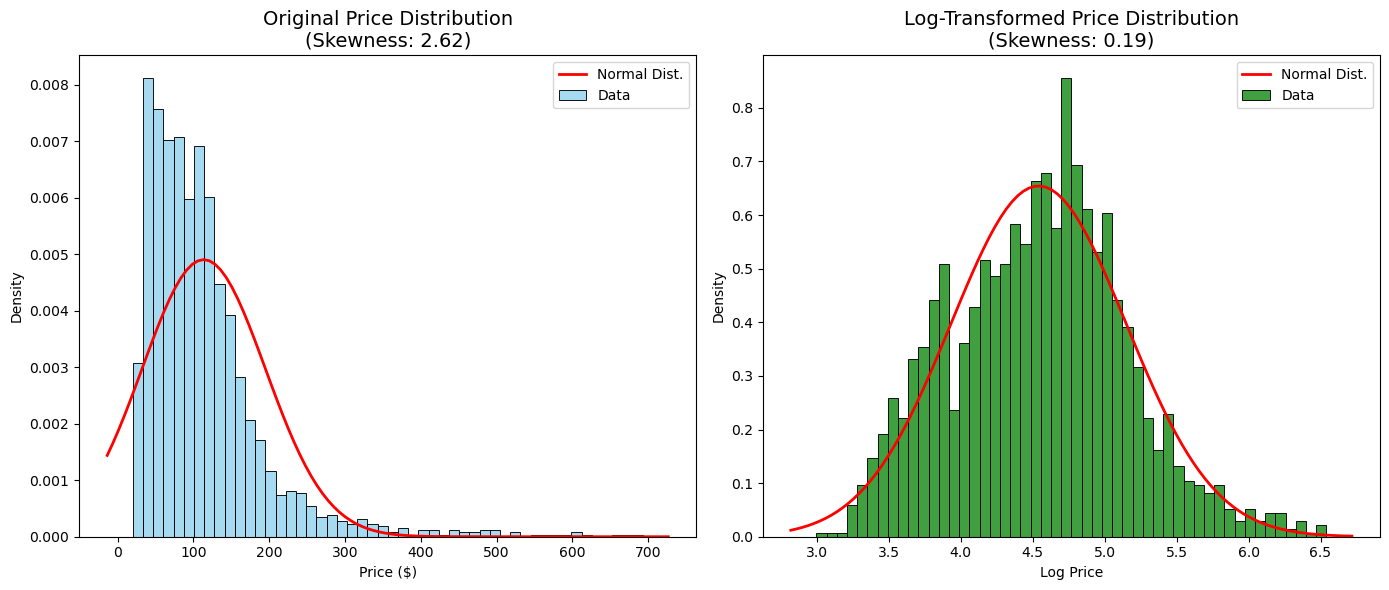

In [100]:
# You might be curious about the distribution of price before and after log transformation. Let's visualize it:

price = df_clean['price']
log_price = df_clean['log_price']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot A: Original Price ---
sns.histplot(price, bins=50, kde=False, color='skyblue', stat='density', ax=axes[0], label='Data')
# Overlay Normal Curve (based on original mean/std)
mu, std = norm.fit(price)
xmin, xmax = axes[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axes[0].plot(x, p, 'r', linewidth=2, label='Normal Dist.')

axes[0].set_title(f'Original Price Distribution\n(Skewness: {price.skew():.2f})', fontsize=14)
axes[0].set_xlabel('Price ($)')
axes[0].legend()

# --- Plot B: Log Transformed Price ---
sns.histplot(log_price, bins=50, kde=False, color='green', stat='density', ax=axes[1], label='Data')
# Overlay Normal Curve (based on log mean/std)
mu_log, std_log = norm.fit(log_price)
xmin, xmax = axes[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_log, std_log)
axes[1].plot(x, p, 'r', linewidth=2, label='Normal Dist.')

axes[1].set_title(f'Log-Transformed Price Distribution\n(Skewness: {log_price.skew():.2f})', fontsize=14)
axes[1].set_xlabel('Log Price')
axes[1].legend()

plt.tight_layout()
plt.show()

You can see now we have a much more symmetric distribution after log transformation, 
which is more suitable for the OLS regression analysis.

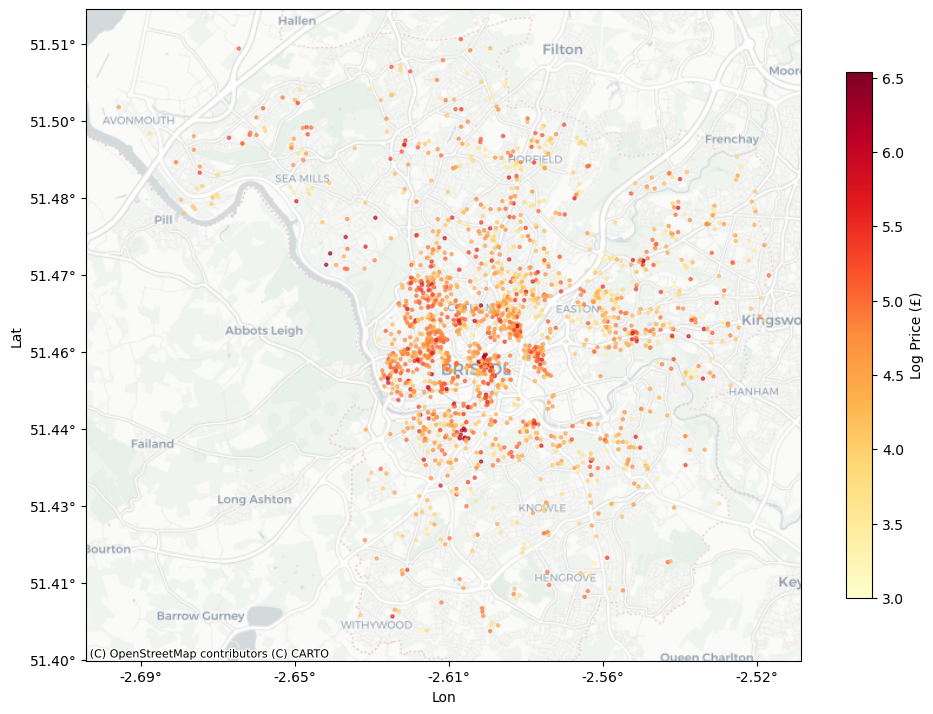

In [ ]:
geometry = [Point(xy) for xy in zip(df_clean['longitude'], df_clean['latitude'])]
gdf = gpd.GeoDataFrame(df_clean, geometry=geometry, crs='EPSG:4326')

gdf_web = gdf.to_crs('EPSG:3857')

fig, ax = plt.subplots(figsize=(10, 8))

gdf_web.plot(
    ax=ax, column='log_price', cmap='YlOrRd',
    markersize=5, alpha=0.6, legend=True,
    legend_kwds={'label': 'Log Price (£)', 'shrink': 0.7}
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

transformer = pyproj.Transformer.from_crs('EPSG:3857', 'EPSG:4326', always_xy=True)

def lon_formatter(x, pos):
    lon, _ = transformer.transform(x, 0)
    return f'{lon:.2f}°'

def lat_formatter(y, pos):
    _, lat = transformer.transform(0, y)
    return f'{lat:.2f}°'

ax.xaxis.set_major_formatter(FuncFormatter(lon_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(lat_formatter))

plt.tight_layout()
plt.show()

### 3 Construct the Spatial Weight Matrix ($W$)

The spatial weight matrix $W$ defines the neighbourhood structure — which observations are considered "neighbours" and how strongly they are connected.

For point data, common approaches include:

| Method | Description | When to Use |
|---|---|---|
| **K-Nearest Neighbours (KNN)** | Each point connects to its $k$ nearest neighbours | When you want a fixed number of neighbours |
| **Distance Band** | Points within a threshold distance are neighbours | When spatial interaction decays with distance |

We use **KNN** as the primary weight matrix for the regression models, as it ensures every observation has at least $k$ neighbours (avoiding islands). Airbnb listings are points, not continuous polygons, If we used a distance band method to define the spatial weight matrix, some isolated rural listings might have 0 neighbors, which break the math and create errors.

**Spatial weight matrix is the basis of the spatial analysis, since it defines the spatial relationships spatially.**

In [80]:
# Extract projected coordinates for distance calculations
gdf_proj = gdf.to_crs('EPSG:27700')
coords = np.column_stack((gdf_proj.geometry.x, gdf_proj.geometry.y))

# ---- KNN Weight Matrix ----
w_knn = KNN.from_array(coords, k=5)
w_knn.transform = 'R'  # Row-standardise

print("=== KNN Spatial Weights (k=5) ===")
print(f"Number of observations: {w_knn.n}")
print(f"Mean number of neighbours: {w_knn.mean_neighbors:.1f}")
print(f"Min neighbours: {w_knn.min_neighbors}")
print(f"Max neighbours: {w_knn.max_neighbors}")

=== KNN Spatial Weights (k=5) ===
Number of observations: 1913
Mean number of neighbours: 5.0
Min neighbours: 5
Max neighbours: 5


### 4 Estimate OLS 

We first estimate a standard OLS model as the baseline:

$$Y = X\beta + \epsilon$$

We then examine the residuals for spatial autocorrelation.

In [81]:
# Dependent variable
y_col = 'log_price'
y = df_clean[[y_col]].values

# Independent variables
room_dummy_cols = [c for c in df_clean.columns if c.startswith('room_') and c != 'room_type']

x_cols = [
    'accommodates', 'bedrooms', 'bathrooms',
    'is_superhost', 'review_scores_rating', 'reviews_per_month',
    'availability_365', 'minimum_nights',
    'is_instant_bookable'
] + room_dummy_cols

# Convert room type dummies to int
for col in room_dummy_cols:
    df_clean[col] = df_clean[col].astype(int)

x = df_clean[x_cols].values


### Variance Inflation Factor (VIF)

The Variance Inflation Factor (VIF) measures how much the variance of an estimated regression coefficient is increased due to multicollinearity. It is calculated for each independent variable $X_i$ using the following formula:$$VIF_i = \frac{1}{1 - R_i^2}$$Where:

$VIF_i$ is the Variance Inflation Factor for the $i^{th}$ predictor.

$R_i^2$ is the coefficient of determination obtained by regressing $X_i$ against all other independent variables in the model.

Interpretation:

$VIF = 1$: The variable is not correlated with other predictors.

$1 < VIF < 5$: The variable is moderately correlated, but generally acceptable.

$VIF > 5$ or $10$: Indicates high multicollinearity. This can make the spatial model estimates unstable or lead to incorrect sign directions for your coefficients.

A simple explanation when $VIF = 10$: all other independent variables explain 90% of the $X_i$, which creates a very high multicollinearity issue here. 

In [84]:
# VIF Check for Multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe of just the independent variables (X)
X_vif = df_clean[x_cols] 

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("Variance Inflation Factor (VIF) Check:")
print("-" * 40)
print(vif_data.sort_values('VIF', ascending=False))
print("-" * 40)
print("Note: VIF > 10 indicates high multicollinearity that may distort spatial coefficients.")

Variance Inflation Factor (VIF) Check:
----------------------------------------
                Variable        VIF
0           accommodates  15.154024
1               bedrooms  14.286140
4   review_scores_rating  12.577215
2              bathrooms   8.887966
6       availability_365   3.818729
5      reviews_per_month   2.250369
10     room_Private room   1.946858
3           is_superhost   1.926437
8    is_instant_bookable   1.661038
7         minimum_nights   1.112466
9        room_Hotel room   1.015625
----------------------------------------
Note: VIF > 10 indicates high multicollinearity that may distort spatial coefficients.


So we have accomodates, bedrooms, review_score_rating, and bathrooms have relatively high VIFs. We will need to remove one variable and see if we can lower the VIF. Since the maximum guest capacity (accommodates) is highly correlated with the number of bedrooms and bathrooms, we will remove it first and see how the VIFs change. 

In [ ]:
# Remove accomodates due to high VIF
x_cols_update = [
    'bedrooms', 'bathrooms',
    'is_superhost', 'review_scores_rating', 'reviews_per_month',
    'availability_365', 'minimum_nights',
    'is_instant_bookable'
] + room_dummy_cols

# Create an updated dataframe of just the independent variables (X)
X_vif = df_clean[x_cols_update] 

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("Variance Inflation Factor (VIF) Check:")
print("-" * 40)
print(vif_data.sort_values('VIF', ascending=False))
print("-" * 40)
print("Note: VIF > 10 indicates high multicollinearity that may distort spatial coefficients.")

Variance Inflation Factor (VIF) Check:
----------------------------------------
               Variable        VIF
3  review_scores_rating  12.267298
1             bathrooms   8.796842
0              bedrooms   5.620009
5      availability_365   3.790188
4     reviews_per_month   2.247623
2          is_superhost   1.926428
9     room_Private room   1.710902
7   is_instant_bookable   1.650181
6        minimum_nights   1.102654
8       room_Hotel room   1.013969
----------------------------------------
Note: VIF > 10 indicates high multicollinearity that may distort spatial coefficients.


In [103]:
# Update X with the new set of independent variables
x_cols = x_cols_update
x = df_clean[x_cols].values


We still have some high VIFs, especially for reviews_scores_rating, but we will proceed with the spatial regression and interpret results with caution.

In [104]:
# Run OLS
ols = OLS(
    y, x,
    w=w_knn,
    name_y=y_col,
    name_x=x_cols,
    name_ds='Bristol Airbnb',
    spat_diag=True  # Request spatial diagnostics including LM tests
)

print(ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Bristol Airbnb
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        1913
Mean dependent var  :      4.5405                Number of Variables   :          11
S.D. dependent var  :      0.6099                Degrees of Freedom    :        1902
R-squared           :      0.6412
Adjusted R-squared  :      0.6393
Sum squared residual:     255.214                F-statistic           :    339.8597
Sigma-square        :       0.134                Prob(F-statistic)     :           0
S.E. of regression  :       0.366                Log likelihood        :    -787.726
Sigma-square ML     :       0.133                Akaike info criterion :    1597.452
S.E of regression ML:      0.3653                Schwarz criterion     :    1658.573

----------------------------------------------------------

### OLS assumption and spatial autocorrelation in OLS residuals

Checking the OLS residuals with Global Moran’s I is a critical diagnostic step to decide if we can use spatial regression for the next step. It tests the fundamental assumption of independence of observations. Standard OLS regression assumes that the **error terms** (the difference between predicted and actual prices) are **random** and **unrelated**. However, in spatial datasets like Bristol Airbnb listings we used here, this assumption is often violated.

Just a recap of the First Law of Geography from Waldo Tobler: "**everything is related to everything else, but near things are more related than distant things.**" This first law of geography is the foundation of the fundamental concepts of spatial dependence and spatial autocorrelation and is the fundamental assumption used in all spatial analysis. 

When a model consistently under-predicts prices in one neighborhood and over-predicts in another, the residuals will exhibit a geographic pattern known as spatial autocorrelation.

Global Moran’s I quantifies this pattern: a statistically significant result indicates that "location" is a missing variable that OLS is failing to account for. If we ignore this and stick with OLS, our coefficient estimates may be biased, and our p-values will be unreliable, potentially leading us to believe a variable is significant when it is actually just picking up a spatial trend. Therefore, a significant global Moran’s I serves as the formal "green light" to transition to spatial regression models, which are specifically designed to internalize these geographic dependencies into the mathematical structure of the model.

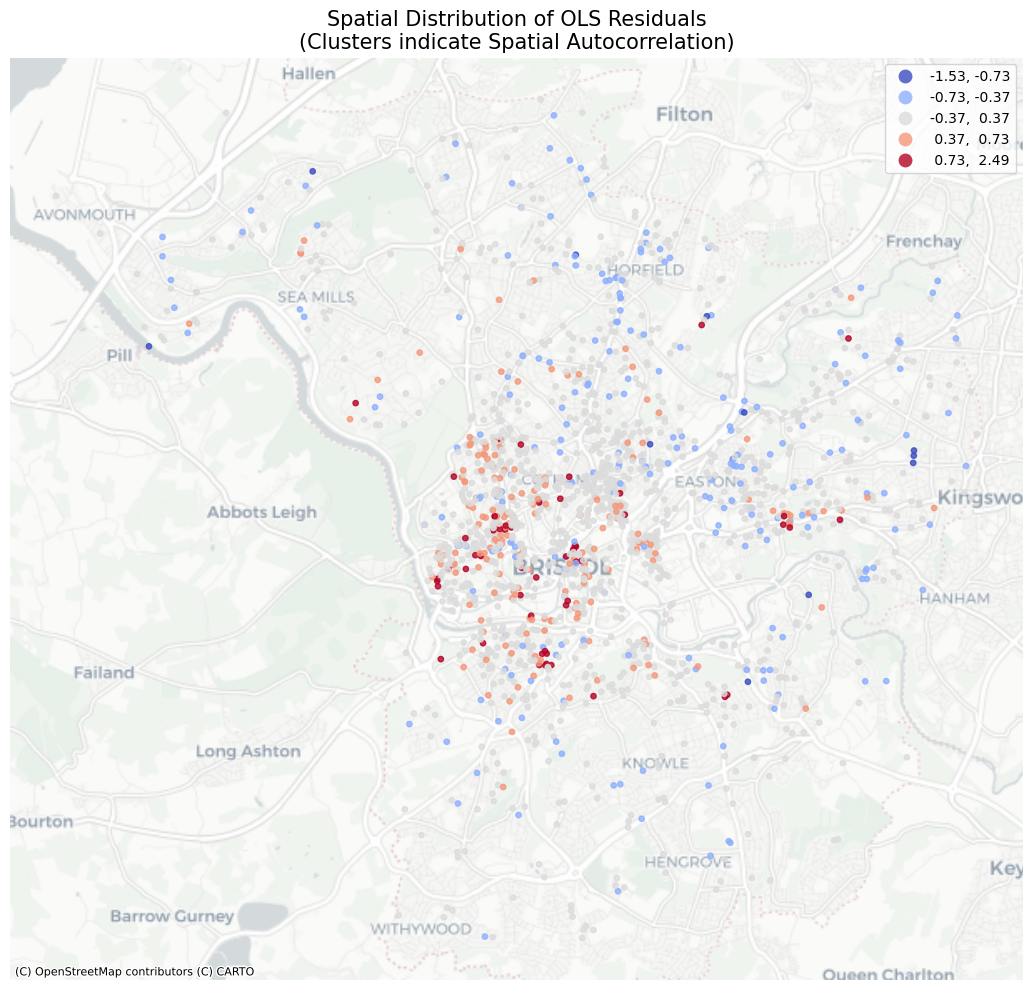

In [105]:
# We will map the OLS residuals to visually inspect for spatial patterns 
# that may indicate spatial autocorrelation (e.g., clusters of high or low residuals).

# 1. Extract residuals from the OLS model object
df_clean['ols_residuals'] = ols.u 

# 2. Create a GeoDataFrame for plotting
gdf_res = gpd.GeoDataFrame(
    df_clean, 
    geometry=gpd.points_from_xy(df_clean.longitude, df_clean.latitude), 
    crs="EPSG:4326"
)

# 3. Plot the residuals
fig, ax = plt.subplots(figsize=(12, 10))

# We reproject to Web Mercator (EPSG:3857) to align with Contextily basemaps
gdf_res_proj = gdf_res.to_crs(epsg=3857)

gdf_res_proj.plot(
    column='ols_residuals', 
    scheme='std_mean', # Standard deviation from mean highlights outliers well
    k=5, 
    cmap='coolwarm',   # Red = High/Positive, Blue = Low/Negative
    legend=True, 
    ax=ax, 
    markersize=15, 
    alpha=0.8
)

# Add a basemap for context
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title('Spatial Distribution of OLS Residuals\n(Clusters indicate Spatial Autocorrelation)', fontsize=15)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [106]:
# Moran's I test for spatial autocorrelation in OLS residuals
residuals = ols.u.flatten()
moran = Moran(residuals, w_knn)

print("=== Global Moran's I Test on OLS Residuals ===")
print(f"Moran's I:     {moran.I:.4f}")
print(f"Expected I:    {moran.EI:.4f}")
print(f"Z-score:       {moran.z_sim:.4f}")
print(f"P-value:       {moran.p_sim:.4f}")
print()

=== Global Moran's I Test on OLS Residuals ===
Moran's I:     0.2789
Expected I:    -0.0005
Z-score:       21.0760
P-value:       0.0010



So from the map and the global moran's I test results, is there spatial autocorrelation in the residuals?

If so, which type of spatial model is appropriate? Now we need the **LM tests** and we formally start to use the spatial regression framework. 


### 5 Estimate spatial regression model 

In this class, we will discuss three spatial regression models, including **Spatial Lag** model, **Spatial Error** model, and **Spatial Dublin** model. There are further models under the Spatial Econometrics framework such as the Spatial Dublin Error model, but we will not cover it here. More information can be found in the session reading list. 

Regardless of the LM test outcome, we estimate all three models here for **demonstration and comparison** purposes. In practice, you would focus on the model indicated by the diagnostic tests.

#### 5.1 Model Selection Decision Tree

When choosing between Spatial Lag and Spatial Error models, we follow the **Anselin-Florax** decision rule based on the Lagrange Multiplier (LM) tests:

1.  **Run OLS** and look at the standard **LM-Lag** and **LM-Error** tests.
2.  **Scenario A:** Neither is significant $\rightarrow$ Stick with **OLS** (data is not spatially dependent).
3.  **Scenario B:** Only one is significant $\rightarrow$ Choose that model (e.g., if LM-Lag is significant, use **Spatial Lag**).
4.  **Scenario C:** Both are significant $\rightarrow$ Look at the **Robust** LM tests:
    * If **Robust LM-Lag** > Robust LM-Error $\rightarrow$ Choose **Spatial Lag**.
    * If **Robust LM-Error** > Robust LM-Lag $\rightarrow$ Choose **Spatial Error**.

*Note: If unsure, or if you suspect both substantive spillovers and omitted variables, the **Spatial Durbin Model (SDM)** is often the safest choice as it generalizes both.*

### 5.2 Spatial Error Model (SEM)

$$y = X\beta + \mu$$
$$\mu = \lambda W\mu + \epsilon$$

The SEM assumes spatial dependence in the **error terms**. The parameter $\lambda$ captures the strength of spatial autocorrelation among the residuals. This means that unobserved factors affecting price are spatially correlated — e.g., neighbourhood characteristics we haven't included in the model.

#### Theoretical Concept: Spatially Correlated Omitted Variables

In any regression, the error term () represents "everything we didn't include in the model." In standard OLS, we assume these errors are random noise. However, in spatial data, the things we forget to include often have a spatial pattern.

The SEM assumes that the spatial dependence arises from **omitted variables** that are shared by neighbors.

* **The "Nuisance" Model:** Econometricians often call SEM a "nuisance" model because the spatial pattern isn't the main thing we are interested in—it's just a problem we need to fix to get our coefficients () right. 

Declaration: as a geographer/urban planner, I always believe **Spatial is Special**. However it is still very important to appropriately incorporate spatial factors into the traditional econometrics framework. 

* **No Feedback Loop:** Unlike the Lag model, a change in my neighbor's *X* affects my *Y*, but my *Y* does not bounce back to affect them.

#### Mathematical Breakdown

The error term is split into two parts:

1. **The Spatial Component:** 
$\lambda W\mu$

This part captures the structure. If my neighbor has a large positive error (e.g., their house is surprisingly expensive for its size), I am likely to have a large positive error too, because we share the same unobserved location features.

2. **(The Random Component):** $\epsilon$. 
Pure white noise.

**Key Parameter:** $\lambda$

* This is the coefficient of spatial error.
* If $\lambda = 0$
the model collapses back to standard OLS.
* If $\lambda$ 
is significant, it proves that OLS residuals were not random and the SEM correction was necessary.

In [107]:
sem = ML_Error(
    y, x,
    w=w_knn,
    name_y=y_col,
    name_x=x_cols,
    name_ds='Bristol Airbnb'
)

print(sem.summary)

/Users/qzhao/opt/anaconda3/envs/regression/lib/python3.14/site-packages/spreg/ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :Bristol Airbnb
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        1913
Mean dependent var  :      4.5405                Number of Variables   :          11
S.D. dependent var  :      0.6099                Degrees of Freedom    :        1902
Pseudo R-squared    :      0.6364
Log likelihood      :   -639.5478
Sigma-square ML     :      0.1092                Akaike info criterion :    1301.096
S.E of regression   :      0.3304                Schwarz criterion     :    1362.216

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         3.91725  

#### 5.3 Spatial Autoregressive Model (SAR / Spatial Lag Model)

$$y = \rho Wy + X\beta + \epsilon$$

The SAR assumes the dependent variable at one location is directly influenced by the dependent variable at **neighbouring locations**. The parameter $\rho$ captures the strength of the spatial lag effect. For Airbnb, this means a listing's price is directly influenced by what nearby listings charge.

While the Spatial Error Model deals with "nuisance" errors, the **Spatial Lag Model (SAR)** captures **substantive** spatial interaction. It assumes that the price of one unit is directly influenced by the prices of its neighbors.

#### Theoretical Concept: Spillovers and Feedback

This model represents a "diffusion" process or a feedback loop.

* **Copycatting / Competition:** "If my neighbor sells their house for a high price, I will increase my asking price too."
* **The Feedback Loop:** If Unit A increases its price, it pulls up Unit B's price. But since Unit B is higher, it pulls up Unit A's price even further. This ripple effect spreads through the entire map.

#### Mathematical Breakdown

The equation adds a new term to the standard OLS formula:

1. **The Spatial Lag Term:** $\rho Wy$

This represents the weighted average of the dependent variable ($y$) in neighboring locations. It effectively treats "Neighbor's Price" as an extra independent variable.

2. **The Structural Component:** $X\beta$

These are the standard attributes (bedrooms, bathrooms) that affect price locally.

#### Key Parameter: $\rho$

* This is the **spatial autoregressive coefficient**.
* **If $\rho>0$:** Positive spatial dependence. High prices cluster near high prices (most common in housing).
* **If $\rho<0$:** Negative spatial dependence. High prices are surrounded by low prices (checkerboard pattern).
* **If $\rho=0$:** There is no spatial interaction; the model collapses back to OLS.

#### Econometric Consequence: Bias

The distinction between Lag and Error is critical here:

* **Ignoring Spatial Error (SEM):** OLS is **Inefficient** (wrong p-values so we can think some coefficient is significant but actually not, but coefficients are okay on average).
* **Ignoring Spatial Lag (SAR):** OLS is **Biased and Inconsistent**.
* Because $y$ appears on both sides of the equation (as $y$ and inside $Wy$), standard OLS breaks down. The coefficients ($\beta$) will be wrong, no matter how much data you have. You *must* use Maximum Likelihood estimation (ML) to fix this.

#### Interpretation Warning: The Multiplier Effect

Because of the feedback loop, you cannot interpret the  coefficients as simple marginal effects (like in OLS).

* **Direct Impact:** The effect of adding a bedroom to *my* house on *my* price.
* **Indirect Impact (Spillover):** The effect of adding a bedroom to *my* house on *my neighbors'* prices.
* **Total Impact:** The sum of both.

In [108]:
sar = ML_Lag(
    y, x,
    w=w_knn,
    name_y=y_col,
    name_x=x_cols,
    name_ds='Bristol Airbnb'
)

print(sar.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :Bristol Airbnb
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        1913
Mean dependent var  :      4.5405                Number of Variables   :          12
S.D. dependent var  :      0.6099                Degrees of Freedom    :        1901
Pseudo R-squared    :      0.6857
Spatial Pseudo R-squared:  0.6394
Log likelihood      :   -676.6057
Sigma-square ML     :      0.1169                Akaike info criterion :    1377.211
S.E of regression   :      0.3419                Schwarz criterion     :    1443.888

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------------

#### 5.4 Spatial Durbin Model (SDM)

The **Spatial Durbin Model (SDM)** is the "general" model that combines features of both the Lag and Error models. It assumes that a listing's price depends on **three** things:

1. Its own characteristics ($X\beta$)
2. The prices of its neighbors ($\rho Wy$) — *Global Spillover*
3. The characteristics of its neighbors ($WX\theta$) — *Local Spillover*

#### Theoretical Concept

The SDM is often the safest starting point because it doesn't force you to choose between "Feedback" (Lag) and "Omitted Variables" (Error). It allows for both:

* **Feedback:** High prices nearby pull my price up ($\rho$).
* **Context:** Being next to a *large* house (Neighbor's $X$) might make my house look small and cheap, or it might signal a wealthy area and make my house expensive ($\theta$).

#### Mathematical Breakdown

The equation includes everything:

1. **Spatial Lag of Y ($\rho Wy$):** The feedback loop. (Same as SAR).
2. **Spatial Lag of X ($WX\theta$):** This is the new part. It represents the **average characteristics of your neighbors**.
* *Example:* If $\theta_{bedrooms} > 0$, it means "Having neighbors with many bedrooms increases my price."

The spatially lagged X variables ($WX$) capture **spillover effects** — how the characteristics of neighbouring listings affect a listing's price.

#### Key Parameters: $\rho$ and $\theta$

* $\rho$: The strength of the price feedback loop.
* $\theta$: A vector of coefficients for the neighboring characteristics.
* *Note:* You will get a $\theta$ coefficient for every $X$ variable (e.g., `lag_bedrooms`, `lag_bathrooms`).

#### Econometric Consequence

$$y = \rho Wy + X\beta + WX\theta + \epsilon$$

The SDM is the most general model, including both the spatial lag of $Y$ ($Wy$) and spatial lags of all independent variables ($WX$). It nests both SAR and SEM as special cases:
- If $\theta = 0$: SDM reduces to **SAR**
- If $\theta = - \rho\beta$: SDM reduces to **SEM**

This is why we sometimes run SDM first and then use the **Likelihood Ratio (LR) Test** to see if we can simplify it down to a SAR or SEM.


In [109]:
# ---- Spatial Durbin Model ----
# spreg doesn't have a direct SDM class, so we manually create WX 
# and include it in the ML_Lag model

wx_cols = ['W_' + col for col in x_cols]
wx_array = np.column_stack([lag_spatial(w_knn, x[:, i]) for i in range(x.shape[1])])

# Combine X and WX
x_sdm = np.hstack([x, wx_array])
x_sdm_names = x_cols + wx_cols


In [27]:
# Estimate SDM as ML_Lag with both X and WX
sdm = ML_Lag(
    y, x_sdm,
    w=w_knn,
    name_y=y_col,
    name_x=x_sdm_names,
    name_ds='Bristol Airbnb (SDM)'
)

print(sdm.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :Bristol Airbnb (SDM)
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        1900
Mean dependent var  :      4.5279                Number of Variables   :          24
S.D. dependent var  :      0.5927                Degrees of Freedom    :        1876
Pseudo R-squared    :      0.7473
Spatial Pseudo R-squared:  0.7071
Log likelihood      :   -427.7156
Sigma-square ML     :      0.0888                Akaike info criterion :     903.431
S.E of regression   :      0.2980                Schwarz criterion     :    1036.622

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------

#### Likelihood Ratio (LR) test 

LR tests allow us to formally test whether the SDM can be simplified:

1. **LR Test: SDM vs SAR** — Tests $H_0: \theta = 0$ (spatial lags of X are unnecessary)
   - If rejected → SDM is preferred over SAR
   - If not rejected → SAR is sufficient

2. **LR Test: SDM vs SEM** — Tests $H_0: \theta + \rho\beta = 0$ (the common factor hypothesis)
   - If rejected → SDM is preferred over SEM
   - If not rejected → SEM is sufficient

In [110]:
# ---- Likelihood Ratio Tests ----
print("=" * 60)
print("LIKELIHOOD RATIO (LR) TESTS")
print("=" * 60)

# LR Test 1: SDM vs SAR (H0: theta = 0, WX terms are unnecessary)
lr_sdm_sar = -2 * (sar.logll - sdm.logll)
df_diff_sar = len(x_cols)  # number of WX variables added
p_sdm_sar = 1 - stats.chi2.cdf(lr_sdm_sar, df_diff_sar)

print(f"\nLR Test: SDM vs SAR")
print(f"  H0: θ = 0 (spatially lagged X variables are unnecessary)")
print(f"  LR statistic: {lr_sdm_sar:.4f}")
print(f"  Degrees of freedom: {df_diff_sar}")
print(f"  P-value: {p_sdm_sar:.4f}")
if p_sdm_sar < 0.05:
    print("  → Reject H0: SDM is preferred over SAR")
else:
    print("  → Cannot reject H0: SAR is sufficient (SDM not needed)")

# LR Test 2: SDM vs SEM
lr_sdm_sem = -2 * (sem.logll - sdm.logll)
df_diff_sem = len(x_cols) + 1  # WX terms + rho
p_sdm_sem = 1 - stats.chi2.cdf(lr_sdm_sem, df_diff_sem)

print(f"\nLR Test: SDM vs SEM")
print(f"  H0: θ + ρβ = 0 (common factor hypothesis)")
print(f"  LR statistic: {lr_sdm_sem:.4f}")
print(f"  Degrees of freedom: {df_diff_sem}")
print(f"  P-value: {p_sdm_sem:.4f}")
if p_sdm_sem < 0.05:
    print("  → Reject H0: SDM is preferred over SEM")
else:
    print("  → Cannot reject H0: SEM is sufficient (SDM not needed)")

# Final recommendation
print("\n" + "=" * 60)
print("FINAL MODEL RECOMMENDATION")
print("=" * 60)
if p_sdm_sar < 0.05 and p_sdm_sem < 0.05:
    print("→ SDM is preferred: Both SAR and SEM are rejected in favour of SDM.")
elif p_sdm_sar >= 0.05 and p_sdm_sem < 0.05:
    print("→ SAR is preferred: SDM does not significantly improve over SAR.")
elif p_sdm_sar < 0.05 and p_sdm_sem >= 0.05:
    print("→ SEM is preferred: SDM does not significantly improve over SEM.")
else:
    print("→ Either SAR or SEM may be sufficient. Choose based on AIC and theory.")


LIKELIHOOD RATIO (LR) TESTS

LR Test: SDM vs SAR
  H0: θ = 0 (spatially lagged X variables are unnecessary)
  LR statistic: 497.7802
  Degrees of freedom: 10
  P-value: 0.0000
  → Reject H0: SDM is preferred over SAR

LR Test: SDM vs SEM
  H0: θ + ρβ = 0 (common factor hypothesis)
  LR statistic: 423.6644
  Degrees of freedom: 11
  P-value: 0.0000
  → Reject H0: SDM is preferred over SEM

FINAL MODEL RECOMMENDATION
→ SDM is preferred: Both SAR and SEM are rejected in favour of SDM.


### 6 Coefficient Comparison Across Models

Since we have a conclusion that SDM is the best model we can fit in the spatial regression framework, let's see how the coefficients have changed compared to the OLS model. 

In [111]:
def get_coefs(model, names):
    coefs = {}
    for i, name in enumerate(names):
        beta = model.betas[i][0] if hasattr(model.betas[i], '__len__') else model.betas[i]
        try:
            # Try z_stat first (spatial models), then t_stat (OLS)
            if hasattr(model, 'z_stat'):
                p = model.z_stat[i][1]
            else:
                p = model.t_stat[i][1]
            sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
        except:
            sig = ''
        coefs[name] = f"{beta:.4f}{sig}"
    return coefs

In [112]:
var_names = ['CONSTANT'] + x_cols
sdm_var_names = ['CONSTANT'] + x_sdm_names

ols_coefs = get_coefs(ols, var_names)
sdm_coefs = get_coefs(sdm, sdm_var_names)


all_vars = sdm_var_names
comparison = pd.DataFrame({
    'OLS': {v: ols_coefs.get(v, '—') for v in all_vars},
    'SDM': {v: sdm_coefs.get(v, '—') for v in all_vars}
})

# Add spatial parameter
comparison.loc['ρ (rho)', :] = ['—', f"{sdm.rho:.4f}"]

print("Coefficient Comparison: OLS vs SDM (*** p<0.01, ** p<0.05, * p<0.1)")
print("=" * 70)
print(comparison.to_string())

Coefficient Comparison: OLS vs SDM (*** p<0.01, ** p<0.05, * p<0.1)
                               OLS         SDM
CONSTANT                 3.9252***   1.9923***
bedrooms                 0.2057***   0.0980***
bathrooms                0.1326***   0.0686***
is_superhost                0.0085   0.0909***
review_scores_rating       0.0434*      0.0042
reviews_per_month       -0.0290***   0.0684***
availability_365         0.0004***  -0.0361***
minimum_nights          -0.0032***   0.0003***
is_instant_bookable      0.1288***   -0.0018**
room_Hotel room             0.0870   0.0698***
room_Private room       -0.6671***      0.0206
W_bedrooms                       —  -0.5041***
W_bathrooms                      —     -0.0160
W_is_superhost                   —  -0.1070***
W_review_scores_rating           —     -0.0221
W_reviews_per_month              —      0.0127
W_availability_365               —     -0.0103
W_minimum_nights                 —   0.0291***
W_is_instant_bookable            —     

What do you find out from the results comparison and does that match better with your assumption? 

### References

- Anselin, L. (1988). *Spatial Econometrics: Methods and Models*. Kluwer Academic Publishers.
- Elhorst, J.P. (2010). Applied Spatial Econometrics: Raising the Bar. *Spatial Economic Analysis*, 5(1), 9-28.
- LeSage, J. & Pace, R.K. (2009). *Introduction to Spatial Econometrics*. CRC Press.
- Montgomery, D.C., Peck, E.A., & Vining, G.G. (2021). *Introduction to Linear Regression Analysis*. Wiley.